In [37]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib as plt
from PIL import Image
sys.path.append('../src')
from utils import *
import seaborn as sns
from matplotlib.lines import Line2D
import cv2

In [39]:
folder   = "SCS 10:250:5 HS nsd_general AE"
log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df.csv"

df = pd.read_csv(log_path)
df.head(26)

# Sample Indicator: 
#   0 --> Ground Truth
#   1 --> Ground Truth CLIP
#   2 --> Decoded CLIP Only
#   3 --> Search Reconstruction

,Unnamed: 0,ID,Iter,Sample Indicator,Strength,Brain Correlation V1,Brain Correlation V2,Brain Correlation V3,Brain Correlation V4,Brain Correlation Early Visual,Brain Correlation Higher Visual,Brain Correlation Unmasked,SSIM,Pixel Correlation,CLIP Pearson,CLIP Two-way
0,0,0,0.0,NaN,1.0000,0.722661,0.781491,0.820475,0.714516,0.759910,0.843566,0.797830,0.239239,0.135294,NaN,NaN
1,1,0,1.0,NaN,0.9994,0.808397,0.851136,0.835094,0.813531,0.822370,0.864414,0.836015,0.185524,0.176673,NaN,NaN
2,2,0,2.0,NaN,0.9952,0.753350,0.835408,0.829228,0.735127,0.794787,0.885693,0.835737,0.204452,0.190302,NaN,NaN
3,3,0,3.0,NaN,0.9838,0.784913,0.841558,0.834689,0.747300,0.807592,0.892797,0.847535,0.188231,0.220050,NaN,NaN
4,4,0,4.0,NaN,0.9616,0.816445,0.849865,0.833773,0.827837,0.821916,0.893748,0.854084,0.199976,0.271145,NaN,NaN
5,5,0,5.0,NaN,0.9250,0.834618,0.875001,0.895647,0.836236,0.852380,0.890310,0.870497,0.230134,0.319430,NaN,NaN
6,6,0,6.0,NaN,0.8704,0.835863,0.838345,0.885970,0.866110,0.843233,0.905424,0.871380,0.183971,0.205030,NaN,NaN
7,7,0,7.0,NaN,0.7942,0.827399,0.879487,0.898281,0.869346,0.858070,0.877540,0.866932,0.175736,0.197112,NaN,NaN
8,8,0,8.0,NaN,0.6928,0.807212,0.885107,0.893768,0.896704,0.855995,0.898558,0.873543,0.185630,0.205642,NaN,NaN
9,9,0,9.0,3.0,0.5626,0.818663,0.880479,0.893228,0.880550,0.855835,0.906886,0.878390,0.183973,0.198894,0.691185,1.0


In [41]:
# Statistical Analysis

# ------------------------------------------ Quantitative Measures -----------------------------
#     Methods       |  PixCorr |  SSIM  |  CLIP |
#                   |          |        |       |          
#  Takagi et al.    |          |        | 77.0% |
#  Stable Diffusion |   .150   |  .325  |       |
#  Brain-Diffuser   |   .254   |  .356  | 91.5% |


df_final_samples = df.loc[(df['Sample Indicator'] == 3.0)]

print("Final Sample Mean SSIM: ", df_final_samples['SSIM'].mean())

print("Final Sample Mean Pixel Correlation: ", df_final_samples['Pixel Correlation'].mean())

print("Final Sample Mean CLIP Pearson: ", df_final_samples['CLIP Pearson'].mean())

print("Final Sample Mean CLIP Two-way: ", df_final_samples['CLIP Two-way'].mean())

Final Sample Mean SSIM:  0.24619865488800002
Final Sample Mean Pixel Correlation:  0.18779825951199997
Final Sample Mean CLIP Pearson:  0.6848930502039999
Final Sample Mean CLIP Two-way:  0.9188355520279999


Text(0.5, 1.0, 'Encoded Brain Pearson Correlation')

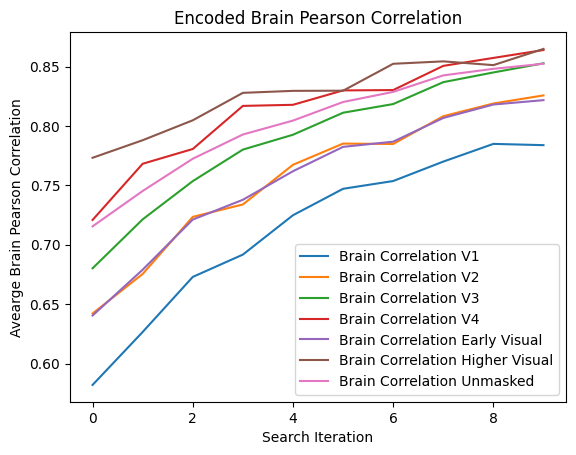

In [43]:
# Average Iteration Brain Region Plot

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_early_visual = []
brain_correlation_higher_visual = []
brain_correlation_unmasked = []

for iteration in range(10):
    brain_correlation_V1.append(df.loc[(df['Iter'] == iteration)]['Brain Correlation V1'].mean())
    brain_correlation_V2.append(df.loc[(df['Iter'] == iteration)]['Brain Correlation V2'].mean())
    brain_correlation_V3.append(df.loc[(df['Iter'] == iteration)]['Brain Correlation V3'].mean())
    brain_correlation_V4.append(df.loc[(df['Iter'] == iteration)]['Brain Correlation V4'].mean())
    brain_correlation_early_visual.append(df.loc[(df['Iter'] == iteration)]['Brain Correlation Early Visual'].mean())
    brain_correlation_higher_visual.append(df.loc[(df['Iter'] == iteration)]['Brain Correlation Higher Visual'].mean())
    brain_correlation_unmasked.append(df.loc[(df['Iter'] == iteration)]['Brain Correlation Unmasked'].mean())
    

plt.plot(brain_correlation_V1, label = 'Brain Correlation V1')
plt.plot(brain_correlation_V2, label = 'Brain Correlation V2')
plt.plot(brain_correlation_V3, label = 'Brain Correlation V3')
plt.plot(brain_correlation_V4, label = 'Brain Correlation V4')
plt.plot(brain_correlation_early_visual, label = 'Brain Correlation Early Visual')
plt.plot(brain_correlation_higher_visual, label = 'Brain Correlation Higher Visual')
plt.plot(brain_correlation_unmasked, label = 'Brain Correlation Unmasked')
plt.legend()
plt.xlabel("Search Iteration")
plt.ylabel("Avearge Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation")


Text(0.5, 1.0, 'Encoded Brain Pearson Correlation Unmasked')

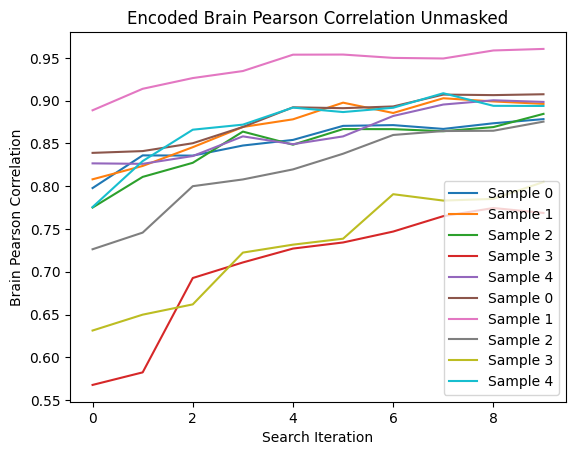

In [45]:
# Single Iteration Brain Region Plot

sample_0 = []
sample_1 = []
sample_2 = []
sample_3 = []
sample_4 = []
sample_5 = []
sample_6 = []
sample_7 = []
sample_8 = []
sample_9 = []

for iteration in range(10):
    sample_0.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 0)]['Brain Correlation Unmasked'])
    sample_1.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 1)]['Brain Correlation Unmasked'])
    sample_2.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 2)]['Brain Correlation Unmasked'])
    sample_3.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 3)]['Brain Correlation Unmasked'])
    sample_4.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 4)]['Brain Correlation Unmasked'])
    sample_5.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 5)]['Brain Correlation Unmasked'])
    sample_6.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 6)]['Brain Correlation Unmasked'])
    sample_7.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 7)]['Brain Correlation Unmasked'])
    sample_8.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 8)]['Brain Correlation Unmasked'])
    sample_9.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 9)]['Brain Correlation Unmasked'])


plt.plot(sample_0, label = 'Sample 0')
plt.plot(sample_1, label = 'Sample 1')
plt.plot(sample_2, label = 'Sample 2')
plt.plot(sample_3, label = 'Sample 3')
plt.plot(sample_4, label = 'Sample 4')
plt.plot(sample_5, label = 'Sample 0')
plt.plot(sample_6, label = 'Sample 1')
plt.plot(sample_7, label = 'Sample 2')
plt.plot(sample_8, label = 'Sample 3')
plt.plot(sample_9, label = 'Sample 4')
plt.legend()
plt.xlabel("Search Iteration")
plt.ylabel("Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation Unmasked")